# import

In [3]:
from control import matlab
from matplotlib import pyplot as plt
import numpy as np
from scipy import linalg as LA

# コントロールクラス

In [4]:
class systemd:
    def __init__(self, A, B, E, C, Ts):
        br, bc = B.shape
        cr, cc = C.shape
        sys1 = matlab.ss(A, B, C, np.zeros((cr, bc)))
        sys1d = matlab.c2d(sys1, Ts)
        br, bc = E.shape
        cr, cc = C.shape
        sys2 = matlab.ss(A, E, C, np.zeros((cr, bc)))
        sys2d = matlab.c2d(sys2, Ts)
        self.A = sys1d.A
        self.B = sys1d.B
        self.E = sys2d.B
        self.C = sys1d.C
        
    def update(self, x1, u1, d1):
        x2 = self.A.dot(x1) + self.B.dot(u1) + self.E.dot(d1)
        y2 = self.C.dot(x1)
        return x2, y2

In [5]:
class mycontrol:
    """
    離散システム用
    y(k+1) = Ad*x(t) + Bd*u(k) + Ed*d(k) 想定
    """
            
    def ss(A, B, E, C, Ts):
        return systemd(A, B, E, C, Ts)
    
    def lqrd(A, B, Q, R):
        """
        離散系最適レギュレータ
        """
        P = LA.solve_discrete_are(A, B, Q, R)
        K = LA.inv(R+B.T.dot(P).dot(B)).dot(B.T).dot(P).dot(A)
        E = None
        
        return P, K, E

# 共通パラメータ

## 入力値

In [57]:
m = 534 # 車体重量 kg
Is = 785 # 車体の慣性モーメント kg*m^2
kf = 13569 # 前輪支持ばね定数 N/m
kr = 17681 # 後輪支持ばね定数 N/m
cf = 1200 # 前輪支持減衰定数 Ns/m
cr = 1299 # 後輪支持減衰定数 Ns/m
a = 1.2 # 車体重心と前輪軸間距離 m
b = 1.3 # 車体重心と後輪軸間距離 m

Ts = 0.001 # サンプリング周期 sec
vhm = 50 # 車両速度 km/h
hd = 0.08 # 外乱高さ m
ld = 3 # 外乱長さ m
dl = 5 # 外乱までの距離 m

q = np.array([1, 100, 1, 1, 1, 1]) # 重み行列Q用 1x6
h = np.array([1, 1])*10**-5 # 重み行列H用 1x2

Cp = np.array(
    [
        [1, 0, 0, 0],
        [0, 0, 1, 0]
    ]
)

## 計算値

In [58]:
l = a+b  # ホイールベース間距離 m
v = vhm*1000/3600  # 車両速度 m/s
Q = np.diag(q)  # 重み行列Q 6x6
H = np.diag(h)  # 重み行列H 2x2

Ap = np.array(
    [
        [0, 1, 0, 0],
        np.array([-(kf+kr), -(cf+cr), kf*a-kr*b, cf*a-cr*b])/m,
        [0, 0, 0, 1],
        np.array([kf*a-kr*b, cf*a-cr*b, -(kf*a*a+kr*b*b), -(cf*a*a+cr*b*b)])/Is
    ]
)
Bp = np.array(
    [
        [0, 0],
        [1/m, 1/m],
        [0, 0],
        [-a/Is, b/Is]
    ]
)
Ep = np.array(
    [
        [0, 0, 0, 0],
        np.array([kf, cf, kr, cr])/m,
        [0, 0, 0, 0],
        np.array([-kf*a, -cf*a, kr*b, cr*b])/Is
    ]
)

# 外乱

In [6]:
def w(x):
    if x <= l:
        return 0
    elif x <= l+ld:
        return hd*(1-np.cos(2*np.pi*(x-l)/ld))/2
    else:
        return 0    

# シミュレーション1 速度一定

## 追加共通パラメータ

In [179]:
start_time = 0
end_time = 2
t = np.arange(start_time, end_time, Ts)

## sim1-1 パッシブモデル

In [169]:
# passive system

In [168]:
sysd = mycontrol.ss(Ap, Bp, Ep, Cp, Ts)

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
ddis = v*Ts

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + ddis
    d[i+1][0][0] = w(dis[i+1]+l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][2][0] = w(dis[i+1])
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts
    
x1, y1, u1, d1, dis1 = x, y, u, d, dis

## sim1-2 フィードバック制御

In [175]:
# feedback system

In [174]:
sysd = mycontrol.ss(Ap, Bp, Ep, Cp, Ts)

q = np.array([1, 100, 1, 1])
Q = np.diag(q)

P, K, E = mycontrol.lqrd(sysd.A, sysd.B, Q, H)
K = -K

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
ddis = v*Ts

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + ddis
    d[i+1][0] = w(dis[i+1]+l)
    d[i+1][1] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][2] = w(dis[i+1])
    d[i+1][3] = (d[i+1][2]-d[i][2])/Ts
    u[i+1] = K.dot(x[i+1])

    
x2, y2, u2, d2, dis2 = x, y, u, d, dis

## sim1_3 エラーシステム

In [181]:
# run error system

In [180]:
sysd = mycontrol.ss(Ap, Bp, Ep, Cp, Ts)
phi = np.vstack(
    (
        np.hstack((np.eye(2), -sysd.C.dot(sysd.A))),
        np.hstack((np.zeros((4,2)), sysd.A))
    )
)
G = np.vstack(
    (
        -sysd.C.dot(sysd.B),
        sysd.B
    )
)
Gd = np.vstack(
    (
        -sysd.C.dot(sysd.E),
        sysd.E
    )
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)
P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
e = np.zeros((t.size, 2, 1))
ddis = v*Ts

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + ddis
    d[i+1][0] = w(dis[i+1]+l)
    d[i+1][1] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][2] = w(dis[i+1])
    d[i+1][3] = (d[i+1][2]-d[i][2])/Ts
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1])+Fx.dot(dx)
    u[i+1] = u[i] + du

    
x3, y3, u3, d3, dis3 = x, y, u, d, dis

## sim1_4 予見制御

In [ ]:
# run preview system

In [239]:
sysd = mycontrol.ss(Ap, Bp, Ep, Cp, Ts)
phi = np.vstack(
    (
        np.hstack((np.eye(2), -sysd.C.dot(sysd.A))),
        np.hstack((np.zeros((4,2)), sysd.A))
    )
)
G = np.vstack(
    (
        -sysd.C.dot(sysd.B),
        sysd.B
    )
)
Gd = np.vstack(
    (
        -sysd.C.dot(sysd.E),
        sysd.E
    )
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)
P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])
step = 43 # 予見ステップ
Fd  = np.zeros((step+1, 2, 4))

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
e = np.zeros((t.size, 2, 1))
yoken = np.zeros((t.size+100, 4, 1))
ddis = v*Ts
Mmax = int(l/(v*Ts))
print(H.shape)

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + ddis
    d[i+1][0] = w(dis[i+1]+l)
    d[i+1][1] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][2] = w(dis[i+1])
    d[i+1][3] = (d[i+1][2]-d[i][2])/Ts
    
    if i<t.size-Mmax-1:
        yoken[i+1+Mmax][2] = d[i+1][0]
        yoken[i+1+Mmax][3] = d[i+1][1]
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1])+Fx.dot(dx)
    for j in range(1, step+1):
        k = j+i
        Fd[j] = -LA.inv(H+G.T.dot(P).dot(G)).dot(G.T).dot(np.linalg.matrix_power((phi+G.dot(K)).T, j)).dot(P).dot(Gd)
        dw = yoken[k+1]-yoken[k]
        du += Fd[j].dot(dw)
    u[i+1] = u[i] + du

x4, y4, u4, d4, dis4 = x, y, u, d, dis

(2, 2)


## プロット

### 状態変数x

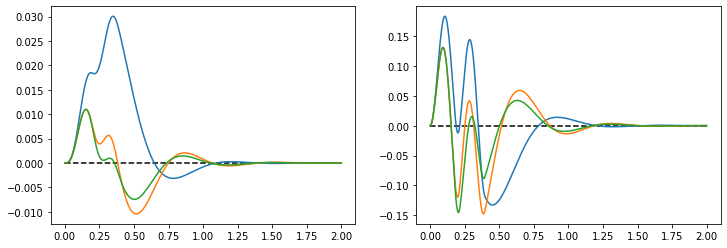

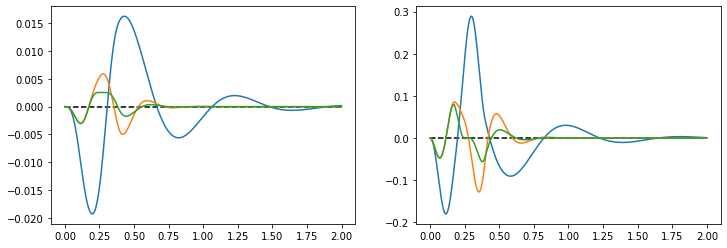

In [240]:
yn = (x2, x3, x4)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 0])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 1])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 2])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 3])
plt.hlines([0], 0, end_time, linestyles='dashed')

### 入力u

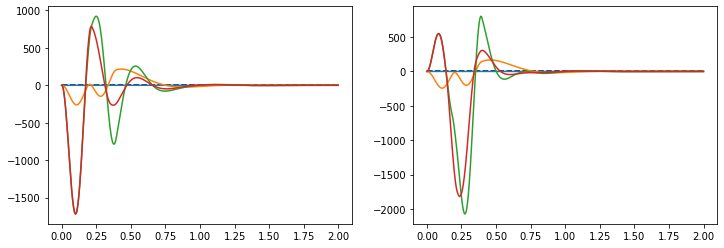

In [242]:
yn = (u1, u2, u3, u4)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 0])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 1])
plt.hlines([0], 0, end_time, linestyles='dashed')

### 外乱d

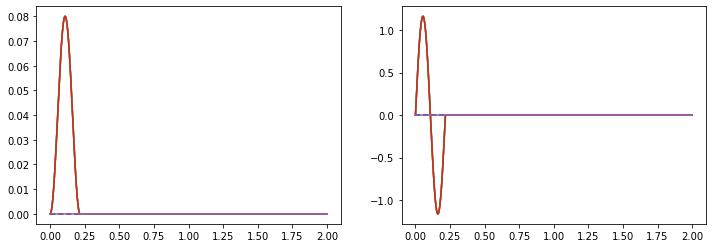

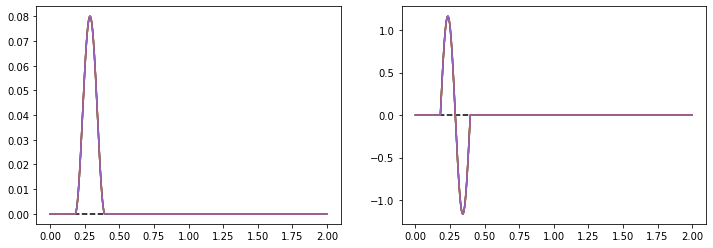

In [215]:
yn = (d1, d2, d3, d4, yoken[:t.size])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 0])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 1])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 2])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 3])
plt.hlines([0], 0, end_time, linestyles='dashed')

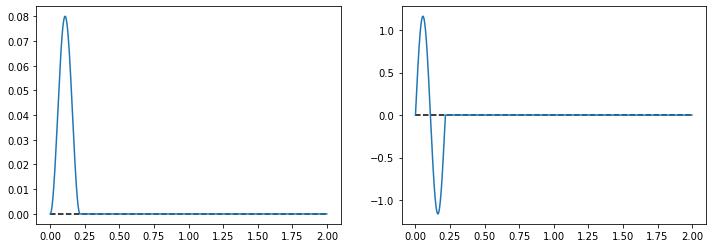

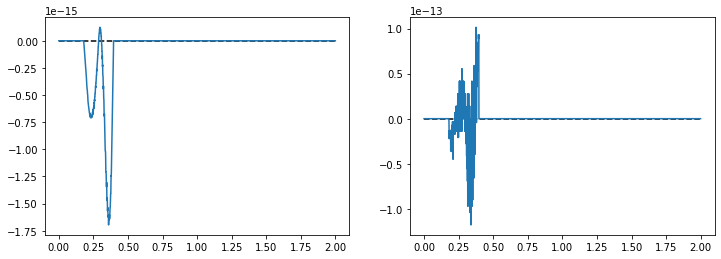

In [213]:
yn = (d4-yoken,)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 0])
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 1])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 2])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 3])
plt.hlines([0], 0, end_time, linestyles='dashed')

# シミュレーション2 加速度一定

## 追加共通パラメータ

In [60]:
start_time = 0
end_time = 2
t = np.arange(start_time, end_time, Ts)

vs = 30
ve = 50
a = ((ve-vs)/2)*Ts

## sim2_1 パッシブモデル

In [62]:
# run passive system

In [61]:
sysd = mycontrol.ss(Ap, Bp, Ep, Cp, Ts)

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0][0] = w(dis[i+1]+l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][2][0] = w(dis[i+1])
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts
    v += a
    
x1, y1, u1, d1, dis1 = x, y, u, d, dis

## プロット

### 状態変数x

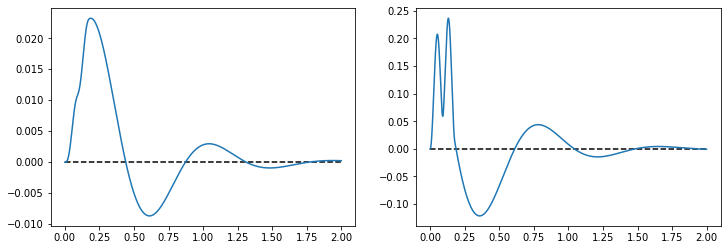

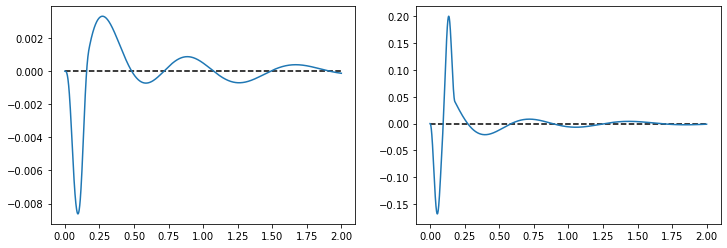

In [63]:
yn = (x1,)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 0])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 1])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 2])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 3])
plt.hlines([0], 0, end_time, linestyles='dashed')

### 入力u

### 外乱d

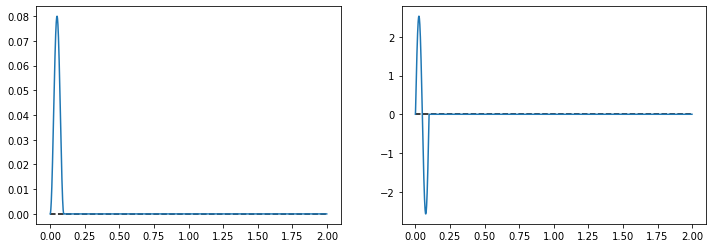

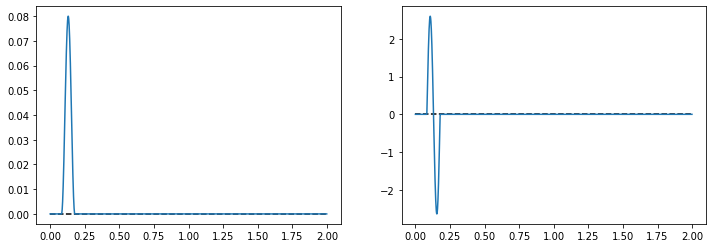

In [64]:
yn = (d1,)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 0])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 1])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 2])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 3])
plt.hlines([0], 0, end_time, linestyles='dashed')

# 実行用コマンド

In [ ]:
# all run

In [7]:
# init

In [59]:
# param_init

In [ ]:
# run_sim1